# Train a Small LLM

# Install Libraries

In [1]:
!pip3 install -q trl peft torch tiktoken datasets transformers textwrap3 matplotlib sentencepiece

# Import Libraries

In [2]:
import torch
from trl import SFTTrainer
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

/opt/homebrew/lib/python3.11/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


# Dataset Exploration

In [3]:
train_dataset = load_dataset("tatsu-lab/alpaca", split="train")

print(train_dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 52002
})


In [4]:
# We can get the first five rows as follows
pandas_format = train_dataset.to_pandas()
display(pandas_format.head())

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....


In [5]:
import textwrap

for index in range(3):
  print("---"*15)
  print("Instruction: {}".format(textwrap.fill(pandas_format.iloc[index]["instruction"], width=50)))
  print("Output: {}".format(textwrap.fill(pandas_format.iloc[index]["output"], width=50)))
  print("Text: {}".format(textwrap.fill(pandas_format.iloc[index]["text"], width=50)))

---------------------------------------------
Instruction: Give three tips for staying healthy.
Output: 1.Eat a balanced diet and make sure to include
plenty of fruits and vegetables.  2. Exercise
regularly to keep your body active and strong.  3.
Get enough sleep and maintain a consistent sleep
schedule.
Text: Below is an instruction that describes a task.
Write a response that appropriately completes the
request.  ### Instruction: Give three tips for
staying healthy.  ### Response: 1.Eat a balanced
diet and make sure to include plenty of fruits and
vegetables.  2. Exercise regularly to keep your
body active and strong.  3. Get enough sleep and
maintain a consistent sleep schedule.
---------------------------------------------
Instruction: What are the three primary colors?
Output: The three primary colors are red, blue, and
yellow.
Text: Below is an instruction that describes a task.
Write a response that appropriately completes the
request.  ### Instruction: What are the three
prima

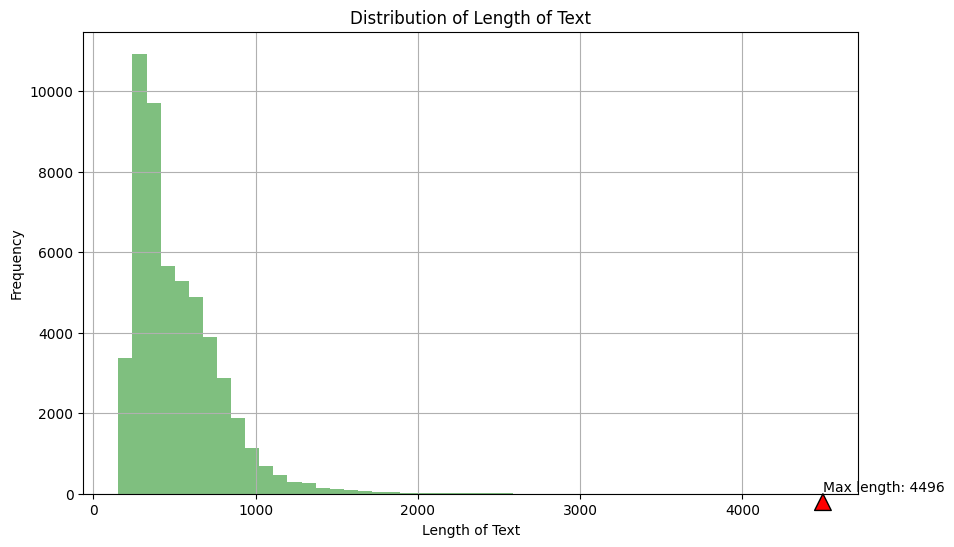

In [6]:
import matplotlib.pyplot as plt

pandas_format['text_length'] = pandas_format['text'].apply(len)

max_length = pandas_format['text_length'].max()

plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')

plt.annotate('Max length: {}'.format(max_length), xy=(max_length, 0), xytext=(max_length, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
mask = pandas_format['text_length'] > 1024
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100

print(f"The percentage of text documents with a length greater than 1024 is: {percentage}%")

The percentage of text documents with a length greater than 1024 is: 4.499826929733472%


# Model Training Prerequisites

The following prerequisites are required for successfully training the model:
- The t5 model is from Google.
- Tokenizer: required for performing the tokenization tasks on the training data.

In [8]:
pretrained_model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(pretrained_model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Use bfloat16 if your machine supports it

In [11]:
model = T5ForConditionalGeneration.from_pretrained(pretrained_model_name, torch_dtype=torch.float32)

In [12]:
# Prepare your training data
# This is a simplified example, you should replace this with your actual training data
inputs = tokenizer("Hello, my name is GitHub Copilot.", return_tensors="pt")
labels = tokenizer("Bonjour, je m'appelle GitHub Copilot.", return_tensors="pt").input_ids

# Initialize LORA parameters
# This is a simplified example, you should replace this with your actual LORA parameters
lora_params = {"alpha": 0.99, "top_p": 0.75}

# Train the model
model.train()
optimizer = AdamW(model.parameters())
for _ in range(100):  # Train for 100 epochs
    optimizer.zero_grad()
    outputs = model(**inputs, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

/opt/homebrew/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
